In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

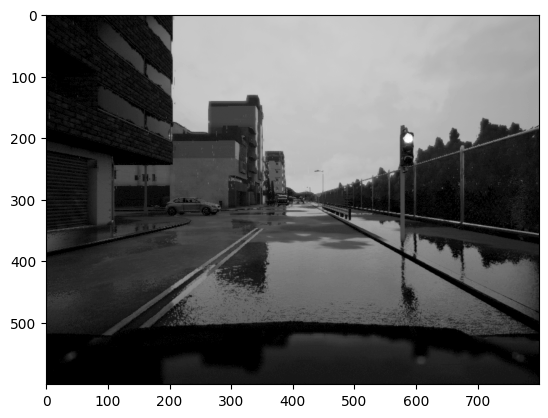

In [2]:
DATA_ROOT = '/kaggle/input/iims-hackathon-2024/SSFSC'
img = plt.imread(DATA_ROOT + '/SSFSC001/images/SSFSC001_0001.png')
plt.imshow(img[..., 0], cmap='gray');


In [3]:
np.unique(img * 255)


array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

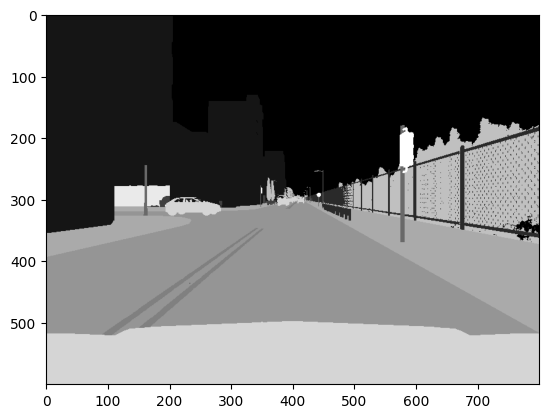

In [4]:
DATA_ROOT = '/kaggle/input/iims-hackathon-2024/SSFSC'
img = plt.imread(DATA_ROOT + '/SSFSC001/masks/SSFSC001_0001.png')
plt.imshow(img[..., 0], cmap='gray');


In [5]:
labels = ['Unlabeled','Building','Fence','Other',
          'Pedestrian', 'Pole', 'Roadline', 'Road',
          'Sidewalk', 'Vegetation', 'Car','Wall',
          'Traffic sign']

[  0 255]


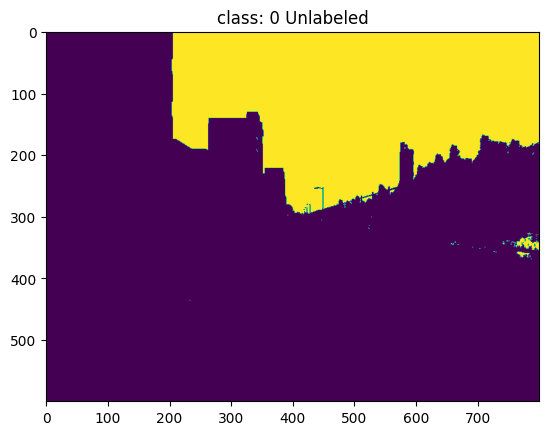

[  0 255]


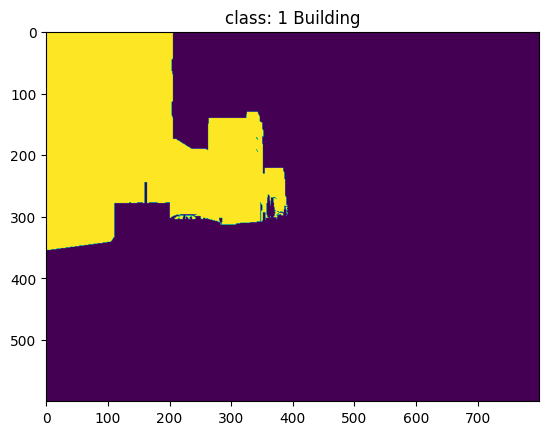

[  0 255]


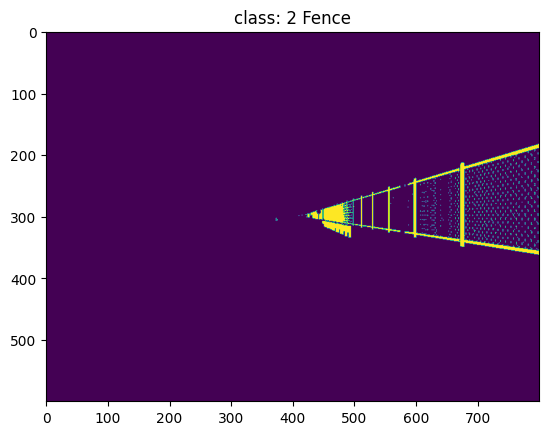

[  0 255]


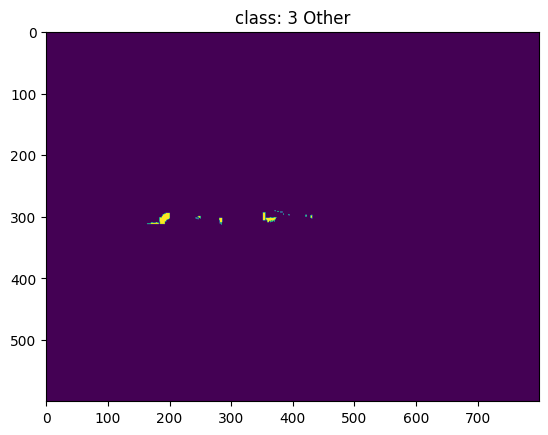

[0]


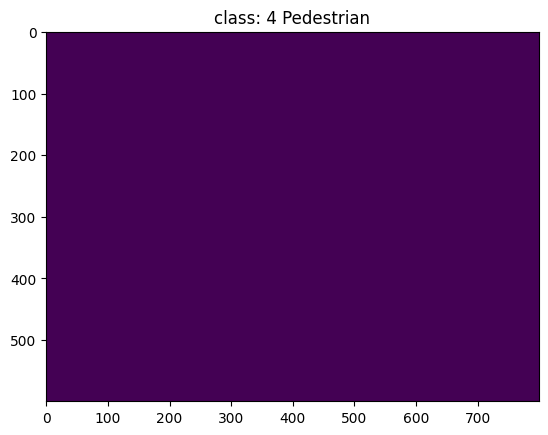

[  0 255]


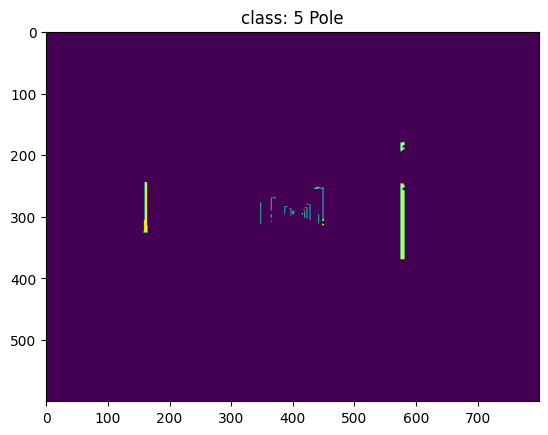

[  0 255]


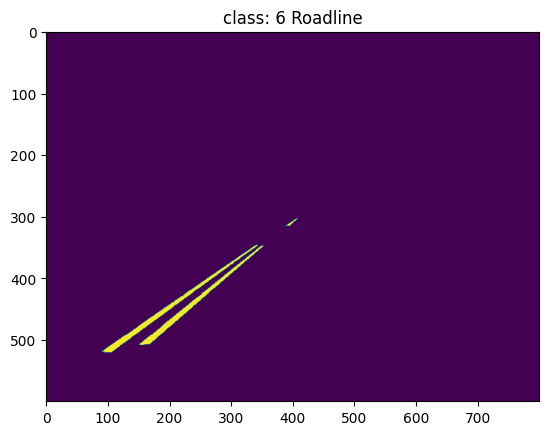

[  0 255]


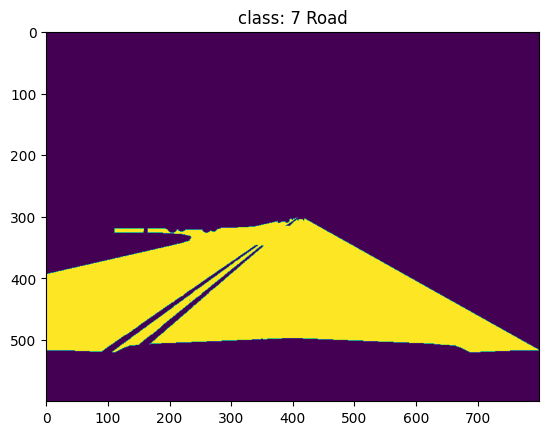

[  0 255]


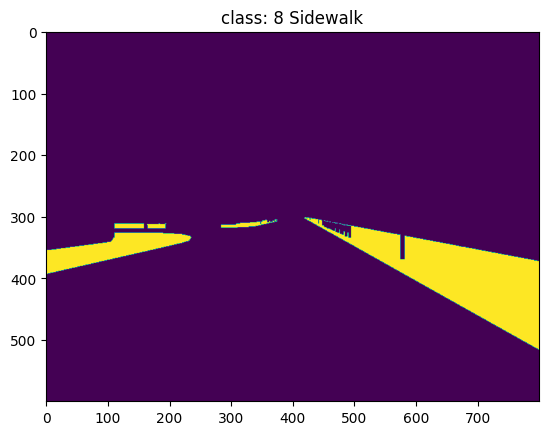

[  0 255]


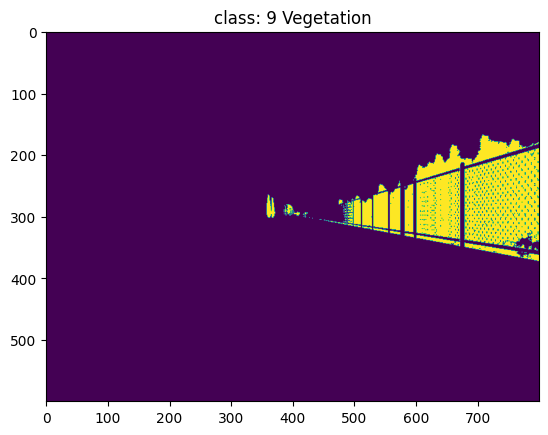

[  0 255]


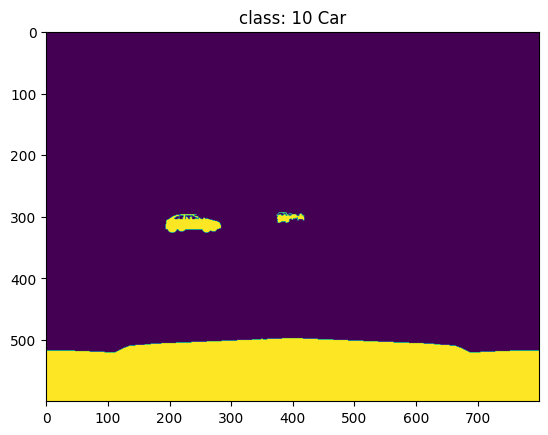

[  0 255]


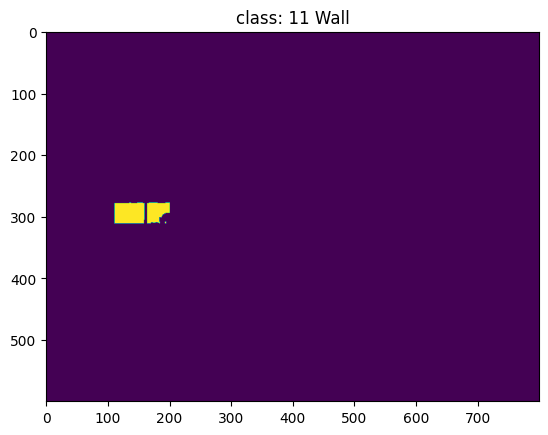

[  0 255]


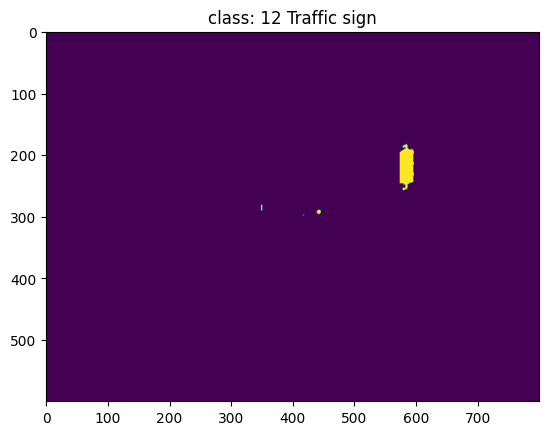

In [6]:
for i in range(13):
    mask = plt.imread(DATA_ROOT + '/SSFSC001/masks/SSFSC001_0001.png') * 255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    print(np.unique(mask))
    plt.title(f'class: {i} {labels[i]}')
    plt.imshow(mask)
    plt.show()

In [7]:
images = []
masks = []
for root, dirs, files in os.walk(DATA_ROOT):
    for name in files:
        f = os.path.join(root, name)
        if 'images' in f:
            images.append(f)
        elif 'masks' in f:
            masks.append(f)
        else:
            break

In [8]:
df = pd.DataFrame({'images': images, 'masks': masks})
# Sorting dataframe by values
df.sort_values(by='images',inplace=True)

df.reset_index(drop=True, inplace=True)
# Displaying first five values
df.head(5)

,images,masks
0,/kaggle/input/iims-hackathon-2024/SSFSC/SSFSC0...,/kaggle/input/iims-hackathon-2024/SSFSC/SSFSC0...
1,/kaggle/input/iims-hackathon-2024/SSFSC/SSFSC0...,/kaggle/input/iims-hackathon-2024/SSFSC/SSFSC0...
2,/kaggle/input/iims-hackathon-2024/SSFSC/SSFSC0...,/kaggle/input/iims-hackathon-2024/SSFSC/SSFSC0...
3,/kaggle/input/iims-hackathon-2024/SSFSC/SSFSC0...,/kaggle/input/iims-hackathon-2024/SSFSC/SSFSC0...
4,/kaggle/input/iims-hackathon-2024/SSFSC/SSFSC0...,/kaggle/input/iims-hackathon-2024/SSFSC/SSFSC0...


In [9]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

In [10]:
class SelfDrivingDataset(Dataset):
    def __init__(self, data, preprocessing=None):
       
        self.data = data
        
        
        self.image_arr = self.data.iloc[:,0]
       
        self.label_arr = self.data.iloc[:,1]
        
        
        self.data_len = len(self.data.index)
        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        
        img = cv2.cvtColor(cv2.imread(self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        
        
        masks = []
        mask = cv2.cvtColor(cv2.imread(self.label_arr[index]), cv2.COLOR_BGR2RGB)
#         mask = Image.open(self.label_arr[index])
#         mask = mask.resize((256, 256))
#         mask = np.asarray(mask)
        
        for i in range(13):
            cls_mask = np.where(mask == i, 255, 0)
            cls_mask = cls_mask.astype('float')
            cls_mask = cv2.resize(cls_mask, (256, 256))

            masks.append(cls_mask[:,:,0] / 255)
            
        masks = torch.as_tensor(masks, dtype=torch.uint8)    
        
            
        return (img.float(), masks)

    def __len__(self):
        return self.data_len

/tmp/ipykernel_24/232260211.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


torch.Size([3, 256, 256]) torch.Size([13, 256, 256])


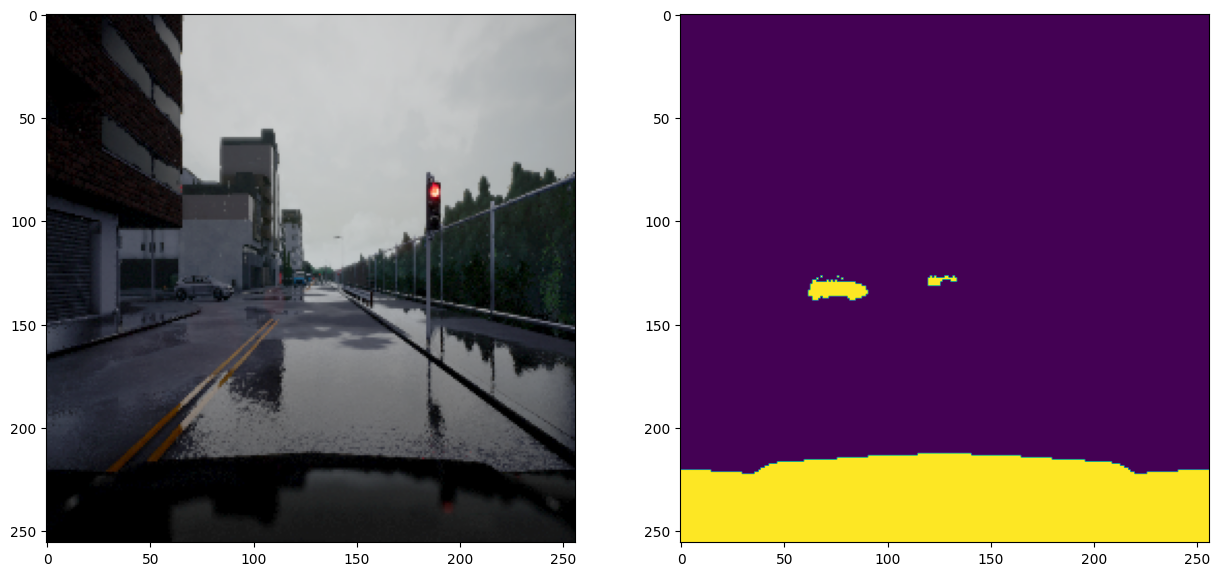

In [11]:
dataset = SelfDrivingDataset(df)
img, masks = dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[..., 10])
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.3)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

train_data = SelfDrivingDataset(X_train)
test_data = SelfDrivingDataset(X_test)

In [13]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=4,
    shuffle=False
)

torch.Size([8, 3, 256, 256]) torch.Size([8, 13, 256, 256])
tensor(0.) tensor(0.9137)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


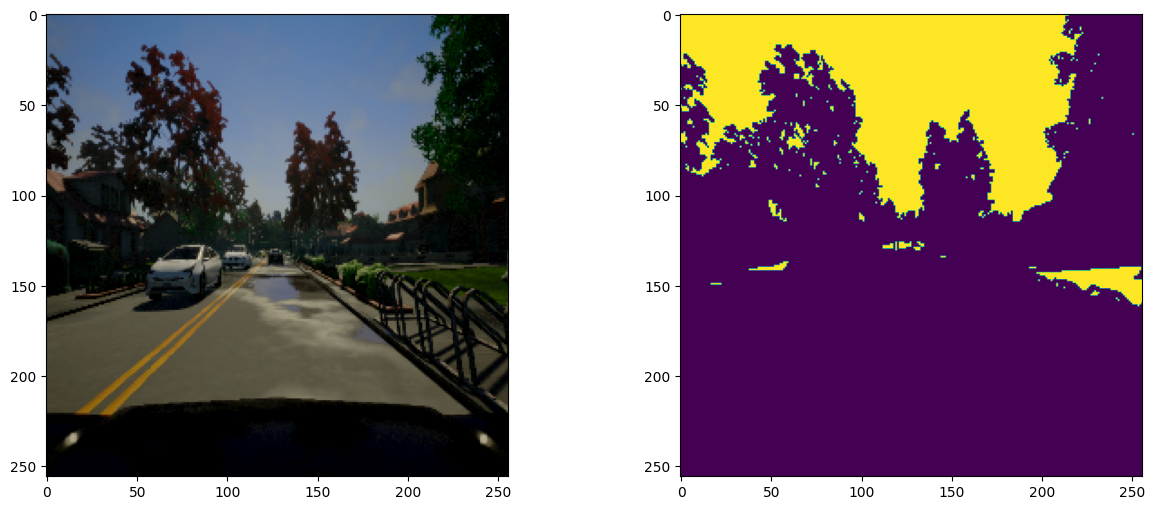

In [14]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[..., 0])
    break

part 2: creating a model

In [15]:
import torch
import torch.nn as nn

def conv_block(in_channels,  out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_channels),
        nn.Conv2d(out_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_channels)
    )
    return conv

In [16]:
class Unet(nn.Module):
    def __init__(self, num_classes):
        super(Unet, self).__init__()

        self.num_classes = num_classes
        self.down_conv_11 = conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = conv_block(in_channels=512, out_channels=1024)

In [17]:
def forward(self, X):
    x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
    x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
    x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
    x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
    x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
    x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
    x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
    x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
    middle_out = self.middle(x8) # [-1, 1024, 16, 16]
    
    self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.up_conv_12 = conv_block(in_channels=1024, out_channels=512)
    self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.up_conv_22 = conv_block(in_channels=512, out_channels=256)
    self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.up_conv_32 = conv_block(in_channels=256, out_channels=128)
    self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.up_conv_42 = conv_block(in_channels=128, out_channels=64)
    self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)


In [18]:
def crop_tensor(target_tensor, tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    
    return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]
    x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
    y = crop_tensor(x, x7)
    x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]

    x = self.up_conv_21(x) # [-1, 256, 64, 64]
    y = crop_tensor(x, x5)
    x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]

    x = self.up_conv_31(x) # [-1, 128, 128, 128]
    y = crop_tensor(x, x3)
    x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]

    x = self.up_conv_41(x) # [-1, 64, 256, 256]
    y = crop_tensor(x, x1)
    x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]

    output = self.output(x) # [-1, num_classes, 256, 256]

    return output

In [19]:
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        self.down_conv_11 = self.conv_block(in_channels=3,
                                            out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2,
                                         stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64,
                                            out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2,
                                         stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128,
                                            out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2,
                                         stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256,
                                            out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2,
                                         stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024,
                                          out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256,
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512,
                                          out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128,
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256,
                                          out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128,
                                          out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes,
                                kernel_size=3, stride=1,
                                padding=1)
        self.softmax = nn.Softmax()
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels),
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]
        output = self.softmax(output)

        return output

In [20]:
learning_rate = 0.001
epochs = 1

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [22]:
Umodel = UNet(num_classes=13).to(device)

In [23]:
sample = (next(iter(train_data_loader)))
sample[1].shape

torch.Size([8, 13, 256, 256])

In [24]:
out = Umodel(sample[0].to(device))
out.shape

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


torch.Size([8, 13, 256, 256])

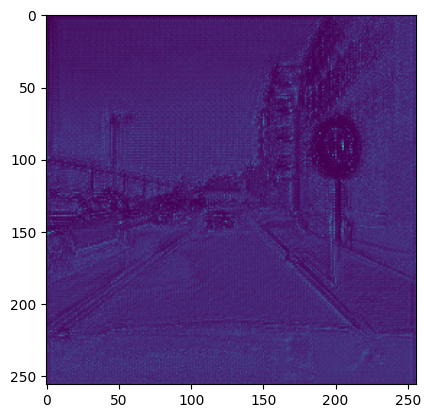

In [25]:
plt.imshow(out[0][2].detach().cpu());

In [26]:
optimizer = torch.optim.Adam(Umodel.parameters())

In [27]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = logits
        m1 = probs.reshape(num, -1)
        m2 = targets.reshape(num, -1)
        intersection = (m1 * m2)

        score = (2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - (score.sum() / num)
        return score

In [28]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

1 epochs, 350 total_steps per epoch


In [29]:
criterion = DiceLoss()

In [30]:
import time

epoch_losses = []
for epoch in range(epochs):
    start_time = time.time()
    epoch_loss = []
    
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = data.to(device), labels.to(device)        
        
        optimizer.zero_grad()
        outputs = Umodel(data)                
        
        #loss = nn.CrossEntropyLoss(outputs,labels)# - torch.log(DiceLoss(outputs, labels))
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
        if batch_idx % 200 == 0:
            print(f'batch index : {batch_idx} | loss : {loss.item()}')

    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    end_time = time.time()
    print(f'Spend time for 1 epoch: {end_time - start_time} sec')
    
    epoch_losses.append(epoch_loss)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


batch index : 0 | loss : 0.9318965673446655
batch index : 200 | loss : 0.16505783796310425
Epoch 1, loss:  0.16499419740268162
Spend time for 1 epoch: 927.6570749282837 sec


In [31]:
save_model_path = './Unet_Model_dice_loss.pth'

In [32]:
torch.save(Umodel.state_dict(), save_model_path)

In [33]:
model_scripted = torch.jit.script(Umodel)
model_scripted.save('modelnew.pt')